# Cardiovascular Disease Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from itertools import product

# data transformation & splitting
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV

# decision tree, logistic
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.linear_model import LogisticRegressionCV

# clustering analysis
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import jaccard_score, adjusted_rand_score, silhouette_score, calinski_harabasz_score, roc_curve, auc, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix

# ensemble methods, MLP
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
#------------------------------------------------------------------------------------------   
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# read data
df = pd.read_csv('cardio_train.csv', sep = ';', index_col = 'id')

# preview
pd.options.display.float_format = '{:,.2f}'.format
display(df.head())

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168   62.00    110     80            1     1      0   
1   20228       1     156   85.00    140     90            3     1      0   
2   18857       1     165   64.00    130     70            3     1      0   
3   17623       2     169   82.00    150    100            1     1      0   
4   17474       1     156   56.00    100     60            1     1      0   

    alco  active  cardio  
id                        
0      0       1       0  
1      0       1       1  
2      0       0       1  
3      0       1       1  
4      0       0       0

# Data Cleaning

### Check missing values:

In [4]:
# check blank rows
df.isnull().sum() 

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

**None of the variables have missing values.**

### Examining the variables:

In [5]:
# before data cleaning
display(df.describe())

age    gender    height    weight     ap_hi     ap_lo  \
count 70,000.00 70,000.00 70,000.00 70,000.00 70,000.00 70,000.00   
mean  19,468.87      1.35    164.36     74.21    128.82     96.63   
std    2,467.25      0.48      8.21     14.40    154.01    188.47   
min   10,798.00      1.00     55.00     10.00   -150.00    -70.00   
25%   17,664.00      1.00    159.00     65.00    120.00     80.00   
50%   19,703.00      1.00    165.00     72.00    120.00     80.00   
75%   21,327.00      2.00    170.00     82.00    140.00     90.00   
max   23,713.00      2.00    250.00    200.00 16,020.00 11,000.00   

       cholesterol      gluc     smoke      alco    active    cardio  
count    70,000.00 70,000.00 70,000.00 70,000.00 70,000.00 70,000.00  
mean          1.37      1.23      0.09      0.05      0.80      0.50  
std           0.68      0.57      0.28      0.23      0.40      0.50  
min           1.00      1.00      0.00      0.00      0.00      0.00  
25%           1.00      1.00      0.00      0.00      1.00      0.00  
50%           1.00      1.00      0.00      0.00      1.00      0.00  
75%           2.00      1.00      0.00      0.00      1.00      1.00  
max           3.00      3.00      1.00      1.00      1.00      1.00

**Age : Converting to years for ease of understanding.**

In [6]:
# convert age from days to years
df['age'] = df['age']/365

**Gender: Converting female to 0 and male to 1**

In [7]:
# convert gender to 0=female and 1=male
df['gender'] = df['gender'] - 1

**Height and Weight : Using BMI as an indicator to remove records that do not make sense.**

count   70,000.00
mean        27.56
std          6.09
min          3.47
25%         23.88
50%         26.37
75%         30.22
max        298.67
Name: BMI, dtype: float64


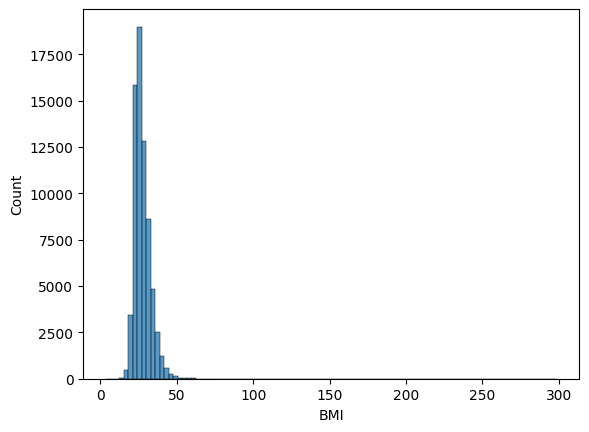

In [8]:
# calculate BMI
df['BMI'] = df['weight']/(np.power(df['height']/100, 2))

# BMI Distribution
print(df['BMI'].describe())
seaborn.histplot(data = df, x = 'BMI', bins = 100)
plt.show()

In [9]:
# remove BMI > 150
drop_criteria_bmi = df[df['BMI'] > 150].index

# number of records to be removed
print(drop_criteria_bmi.size)

# remove records
df.drop(drop_criteria_bmi, inplace = True)

13


**AP_HI and AP_LO : Blood pressure should always be positive, not exceeding a certain threshold (300). AP_HI > AP_LO checking should be enforced.**

In [10]:
# ap_hi is higher than 250 or lower than 60
drop_criteria_aphi = df[(df['ap_hi'] > 210) | (df['ap_hi'] < 60)].index

# ap_lo is higher than 200 or lower than 10
drop_criteria_aplo = df[(df['ap_lo'] > 140) | (df['ap_lo'] < 30)].index

# ap_lo is higher than 'ap_hi
drop_criteria_ap = df[df['ap_lo'] > df['ap_hi']].index 

# number of records to be removed
drop_criteria = drop_criteria_aphi.union(drop_criteria_aplo)
drop_criteria.union(drop_criteria_ap)
print(drop_criteria.size)

1276


In [11]:
# remove the records
df.drop(drop_criteria, inplace = True)

### Data cleaning result:

In [12]:
# after data cleaning
display(df.describe())

# distribution of response variable
display(pd.DataFrame(df['cardio'].value_counts()))

age    gender    height    weight     ap_hi     ap_lo  \
count 68,711.00 68,711.00 68,711.00 68,711.00 68,711.00 68,711.00   
mean      53.33      0.35    164.38     74.11    126.57     81.33   
std        6.76      0.48      8.08     14.30     16.62      9.51   
min       29.58      0.00     64.00     11.00     60.00     30.00   
25%       48.37      0.00    159.00     65.00    120.00     80.00   
50%       53.98      0.00    165.00     72.00    120.00     80.00   
75%       58.42      1.00    170.00     82.00    140.00     90.00   
max       64.97      1.00    250.00    200.00    210.00    140.00   

       cholesterol      gluc     smoke      alco    active    cardio       BMI  
count    68,711.00 68,711.00 68,711.00 68,711.00 68,711.00 68,711.00 68,711.00  
mean          1.36      1.23      0.09      0.05      0.80      0.49     27.49  
std           0.68      0.57      0.28      0.23      0.40      0.50      5.51  
min           1.00      1.00      0.00      0.00      0.00      0.00      3.47  
25%           1.00      1.00      0.00      0.00      1.00      0.00     23.88  
50%           1.00      1.00      0.00      0.00      1.00      0.00     26.35  
75%           1.00      1.00      0.00      0.00      1.00      1.00     30.12  
max           3.00      3.00      1.00      1.00      1.00      1.00    148.93

count
cardio       
0       34725
1       33986

**The data is balanced. There is a fairly even split between individuals with the disease and without the disease.**

# Visualizing Variables

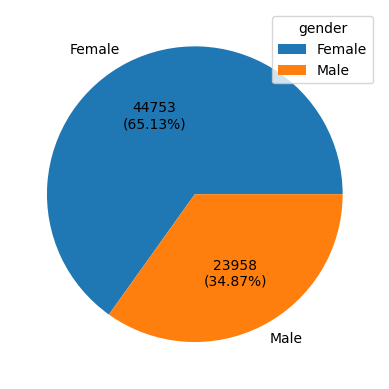

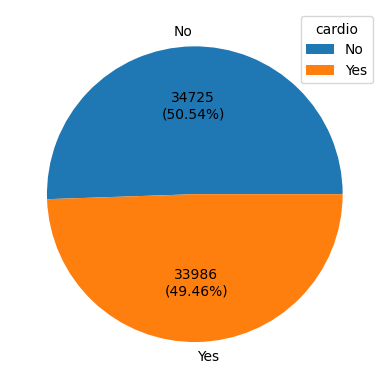

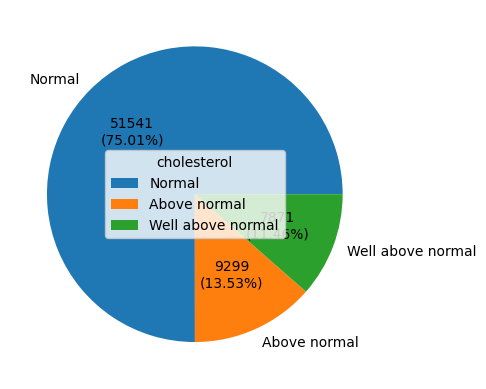

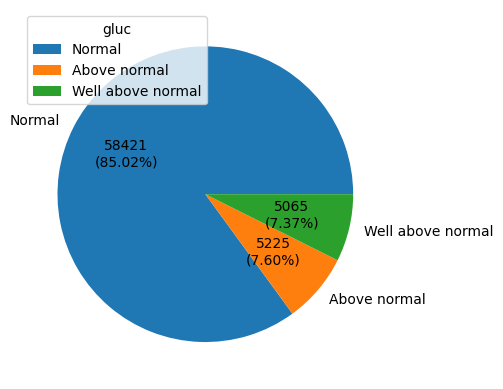

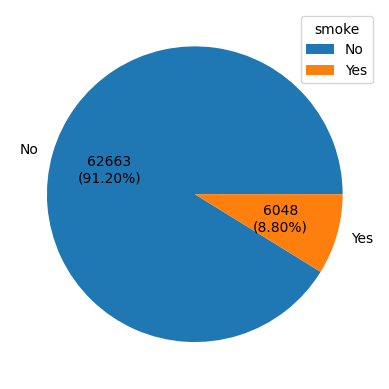

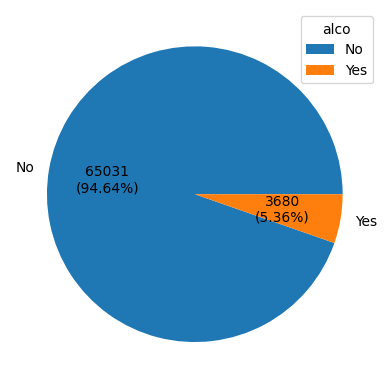

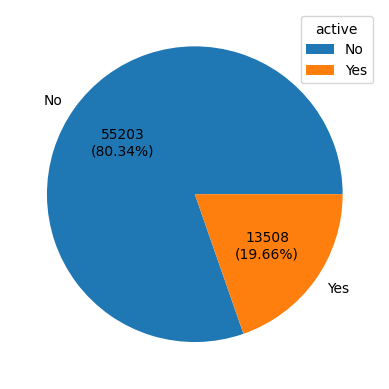

In [13]:
def pie_chart(df, col, labels):
    data = df[col].value_counts().to_numpy()
    def absolute_value(val):
        a  = np.round(val / 100 * data.sum(), 0)
        return str('%0.0f' % a) + '\n(' + ('%0.2f' % val) + '%)'
    plt.pie(data, labels = labels, autopct=absolute_value)
    plt.legend(title=col)
    plt.show() 

pie_chart(df, 'gender', ['Female', 'Male'])
pie_chart(df, 'cardio', ['No', 'Yes'])
pie_chart(df, 'cholesterol', ['Normal', 'Above normal', 'Well above normal'])
pie_chart(df, 'gluc', ['Normal', 'Above normal', 'Well above normal'])
pie_chart(df, 'smoke', ['No', 'Yes'])
pie_chart(df, 'alco', ['No', 'Yes'])
pie_chart(df, 'active', ['No', 'Yes'])

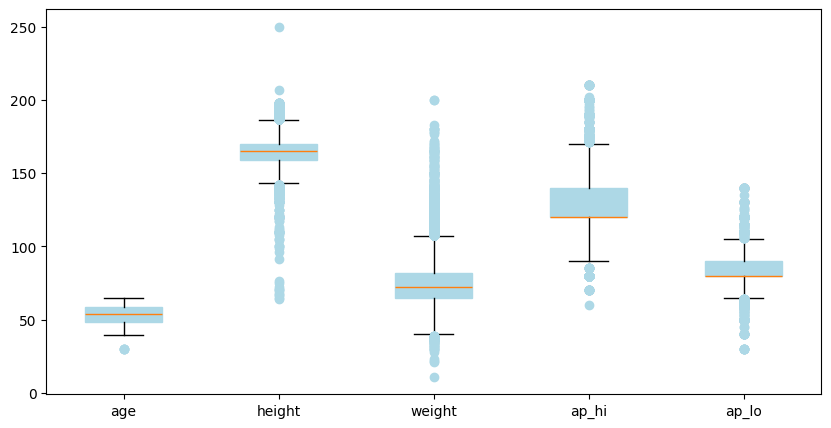

<Axes: >

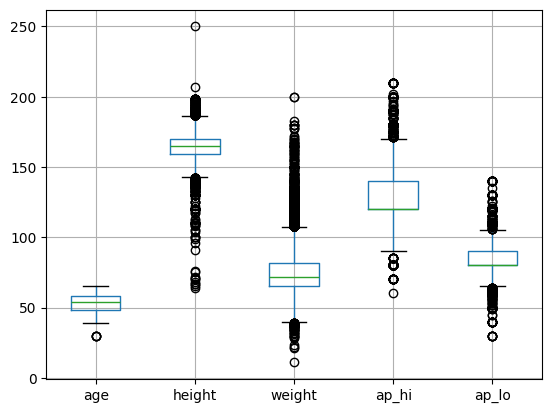

In [14]:
df_subset = df[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
flierprops = dict(markerfacecolor='lightblue', marker='o',markeredgecolor='lightblue') 
# <=> rs = {'markerfacecolor'='lightblue', 'marker'='o'}
boxprops = dict(facecolor='lightblue',color = 'lightblue') # color: box line color; facecolor: fill-in color
plt.figure(figsize=(10, 5))
plt.boxplot(df_subset.values,labels=df_subset.columns,
           flierprops=flierprops,boxprops=boxprops,
            patch_artist=True)
plt.show()
df_subset.boxplot()

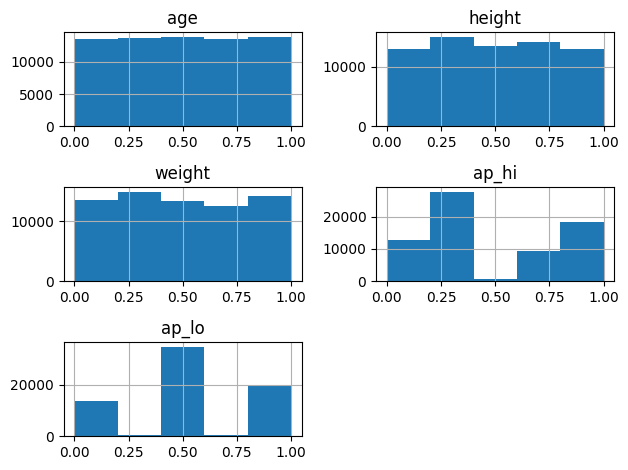

In [15]:
from sklearn.preprocessing import QuantileTransformer
quantile_transformer = QuantileTransformer(random_state=0)
X_trans = quantile_transformer.fit_transform(df_subset)
pd.DataFrame(X_trans, columns=df_subset.columns).hist(bins = 5)
plt.tight_layout()

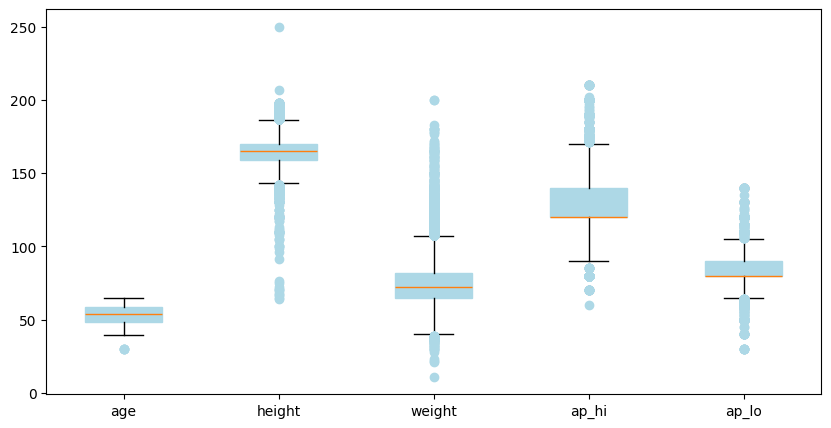

In [16]:
flierprops = dict(markerfacecolor='lightblue', marker='o',markeredgecolor='lightblue') 
# <=> rs = {'markerfacecolor'='lightblue', 'marker'='o'}
boxprops = dict(facecolor='lightblue',color = 'lightblue') # color: box line color; facecolor: fill-in color
plt.figure(figsize=(10, 5))
plt.boxplot(df_subset.values,labels=df_subset.columns,
           flierprops=flierprops,boxprops=boxprops,
            patch_artist=True)
plt.show()

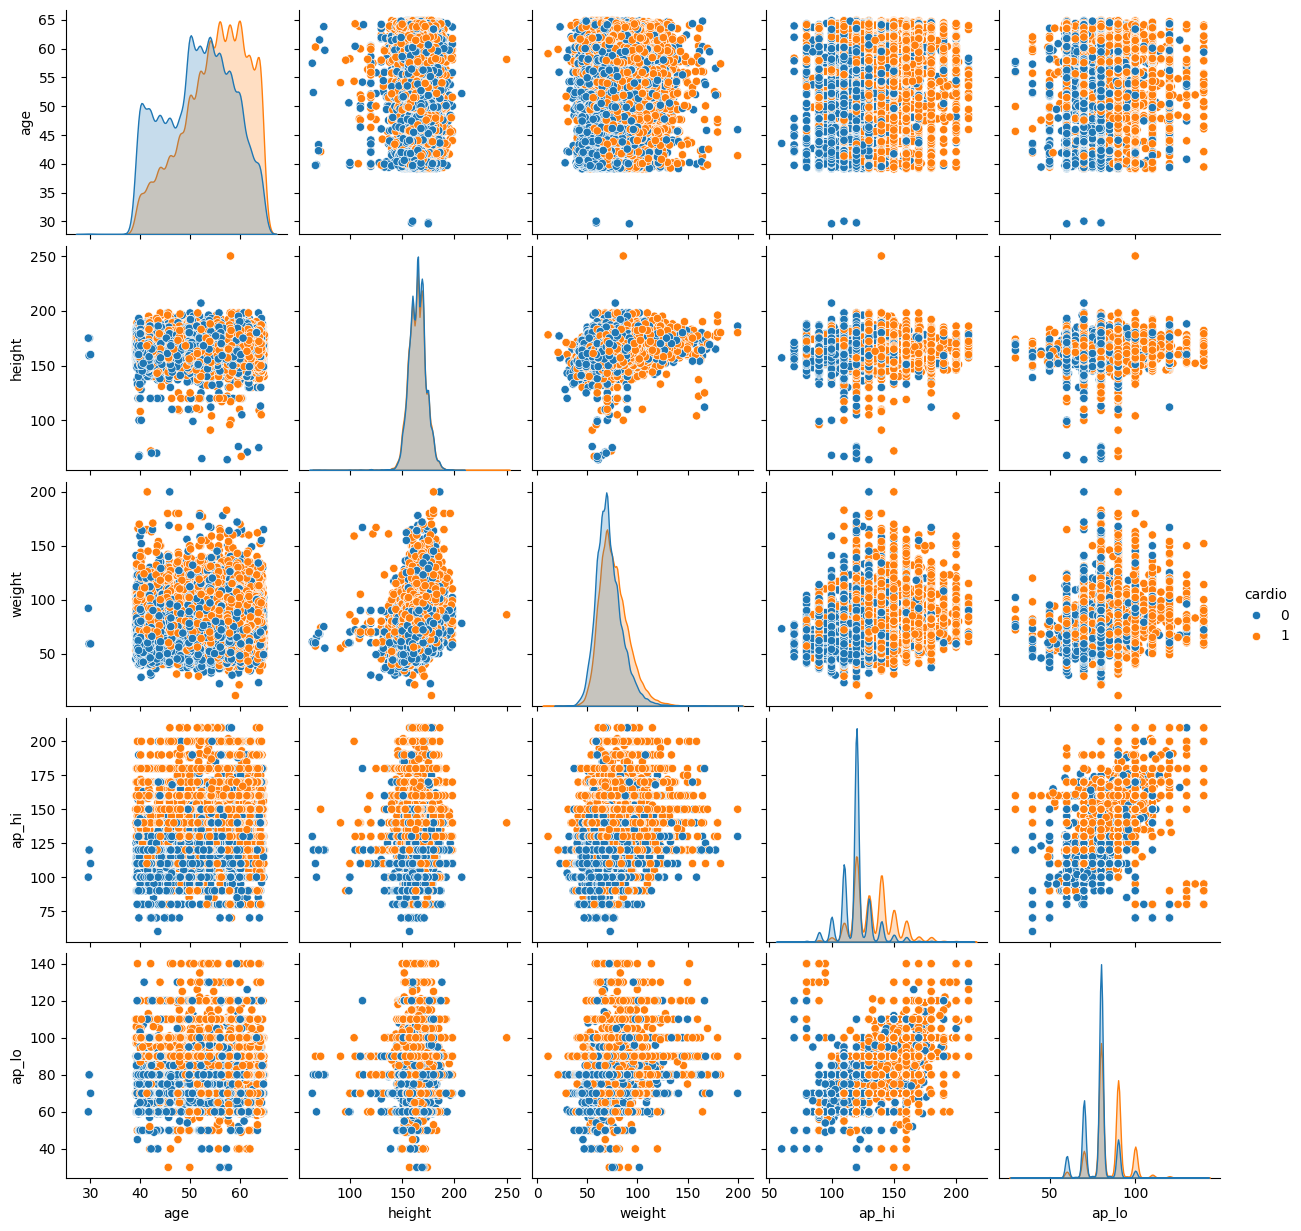

CPU times: user 35.9 s, sys: 666 ms, total: 36.6 s
Wall time: 31.7 s


In [17]:
%%time

# pair-plot
seaborn.pairplot(df, vars = ['age', 'height', 'weight', 'ap_hi', 'ap_lo'], hue = 'cardio')
plt.show()

# Pairplots by gender

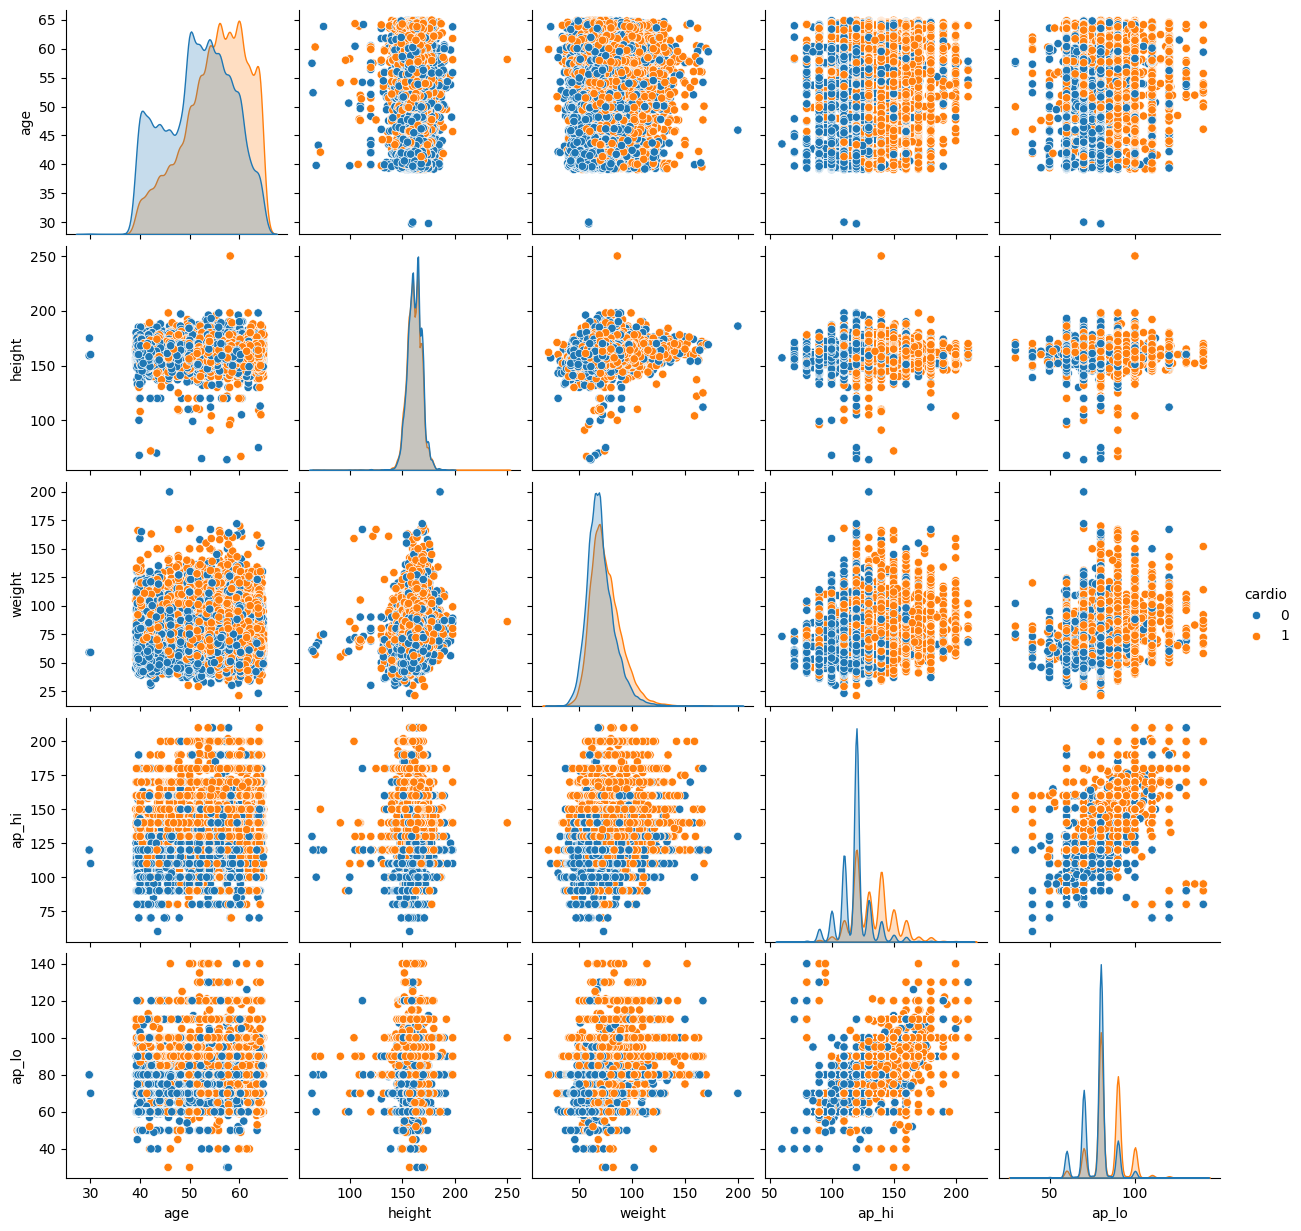

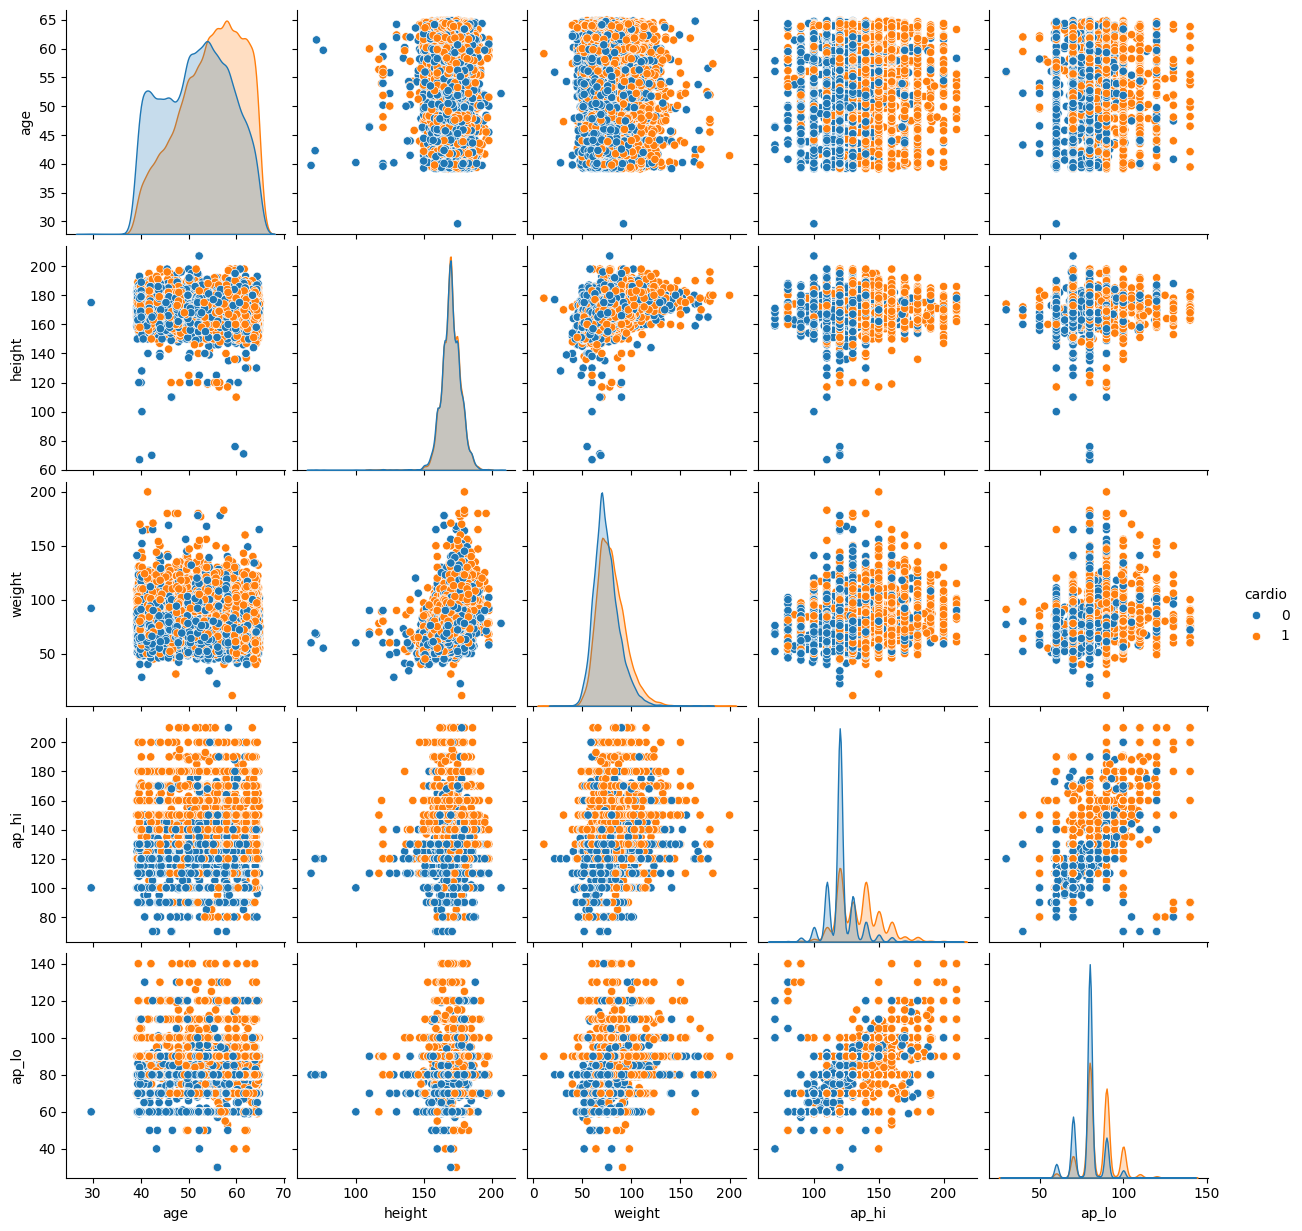

In [18]:
# gender pair-plot
seaborn.pairplot(df[df.gender == 0], vars = ['age', 'height', 'weight', 'ap_hi', 'ap_lo'], hue = 'cardio')
plt.show()
seaborn.pairplot(df[df.gender == 1], vars = ['age', 'height', 'weight', 'ap_hi', 'ap_lo'], hue = 'cardio')
plt.show()

# Correlation heatmap

<Axes: >

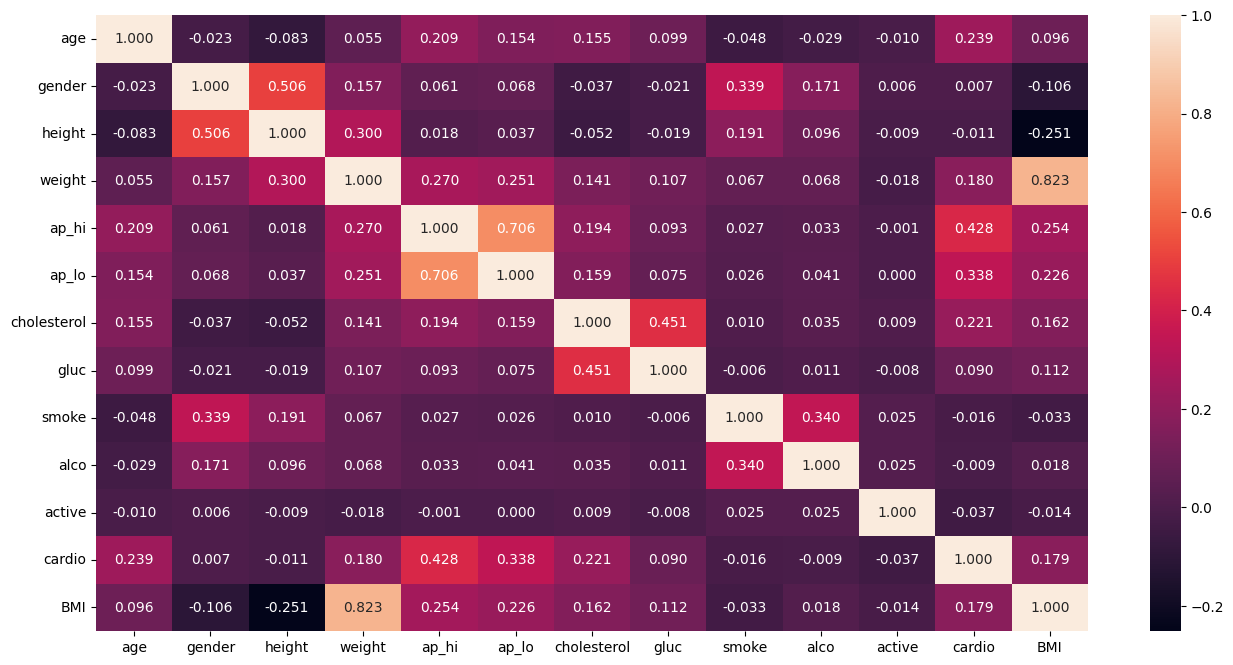

In [19]:
# correlation heatmap
plt.figure(figsize=(16, 8))
seaborn.heatmap(df.corr(), annot=True, fmt='.3f')

# Data Transformation & Train-Test Splitting 

In [20]:
# explanatory variables
x = df.drop(columns = ['cardio', 'BMI'])

# response variable
y = df['cardio']

In [21]:
# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 8017)

# RobustScaler ALL variables
scaler = RobustScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

pd.options.display.float_format = '{:,.4f}'.format
display(x_train.head(5))
display(x_train.describe())

age  gender  height  weight   ap_hi   ap_lo  cholesterol   gluc  \
id                                                                          
2319  -0.0293  0.0000 -0.7273  0.0000  0.0000  0.0000       1.0000 1.0000   
47870  0.4019  0.0000 -0.5455  0.9412 -0.5000 -1.0000       0.0000 0.0000   
65607 -0.4431  1.0000  0.8182  0.4706  1.0000  0.0000       1.0000 0.0000   
58447  0.7868  0.0000  0.3636  1.9412  0.0000  0.0000       2.0000 0.0000   
60084  0.8070  0.0000 -0.4545 -0.6471  0.0000  0.0000       0.0000 0.0000   

       smoke   alco  active  
id                           
2319  0.0000 0.0000  0.0000  
47870 0.0000 0.0000  0.0000  
65607 1.0000 0.0000  0.0000  
58447 0.0000 0.0000  0.0000  
60084 0.0000 0.0000  0.0000

age      gender      height      weight       ap_hi       ap_lo  \
count 41,226.0000 41,226.0000 41,226.0000 41,226.0000 41,226.0000 41,226.0000   
mean      -0.0664      0.3509     -0.0540      0.1218      0.3254      0.1269   
std        0.6746      0.4773      0.7340      0.8407      0.8318      0.9533   
min       -2.4300      0.0000     -9.1818     -3.5882     -2.5000     -5.0000   
25%       -0.5593      0.0000     -0.5455     -0.4118      0.0000      0.0000   
50%        0.0000      0.0000      0.0000      0.0000      0.0000      0.0000   
75%        0.4407      1.0000      0.4545      0.5882      1.0000      1.0000   
max        1.0929      1.0000      7.7273      7.5294      4.5000      6.0000   

       cholesterol        gluc       smoke        alco      active  
count  41,226.0000 41,226.0000 41,226.0000 41,226.0000 41,226.0000  
mean        0.3652      0.2237      0.0891      0.0540     -0.1961  
std         0.6792      0.5699      0.2848      0.2261      0.3970  
min         0.0000      0.0000      0.0000      0.0000     -1.0000  
25%         0.0000      0.0000      0.0000      0.0000      0.0000  
50%         0.0000      0.0000      0.0000      0.0000      0.0000  
75%         1.0000      0.0000      0.0000      0.0000      0.0000  
max         2.0000      2.0000      1.0000      1.0000      0.0000

# Decision Tree

In [22]:
%%time

# parameters candidates
parameters = {'max_depth':range(2,32)}

# fitting
DecisionTree_GSCV = GridSearchCV(DecisionTreeClassifier(random_state=8017), 
                                 parameters, n_jobs=-1, verbose=3, return_train_score=True)
DecisionTree_GSCV.fit(x_train, y_train)
DecisionTree_model = DecisionTree_GSCV.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[CV 4/5] END ...max_depth=2;, score=(train=0.715, test=0.706) total time=   0.0s
[CV 2/5] END ...max_depth=2;, score=(train=0.714, test=0.714) total time=   0.0s
[CV 3/5] END ...max_depth=2;, score=(train=0.713, test=0.716) total time=   0.0s
[CV 1/5] END ...max_depth=3;, score=(train=0.724, test=0.730) total time=   0.0s
[CV 1/5] END ...max_depth=2;, score=(train=0.713, test=0.716) total time=   0.0s
[CV 3/5] END ...max_depth=3;, score=(train=0.724, test=0.729) total time=   0.0s
[CV 5/5] END ...max_depth=2;, score=(train=0.713, test=0.715) total time=   0.0s
[CV 5/5] END ...max_depth=3;, score=(train=0.725, test=0.726) total time=   0.0s
[CV 4/5] END ...max_depth=3;, score=(train=0.727, test=0.717) total time=   0.0s
[CV 2/5] END ...max_depth=3;, score=(train=0.725, test=0.726) total time=   0.0s
[CV 1/5] END ...max_depth=4;, score=(train=0.728, test=0.732) total time=   0.0s
[CV 2/5] END ...max_depth=4;, score=(train=0.729, test=0.727) total time=   0.0s
[CV 3/5] END ...max_depth=4;

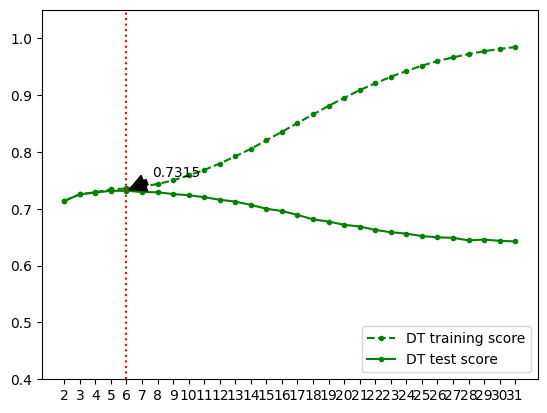

In [23]:
# plot training & testing scores
train_dt_scores = DecisionTree_GSCV.cv_results_['mean_train_score']
test_dt_scores = DecisionTree_GSCV.cv_results_['mean_test_score']

plt.plot(train_dt_scores, "g.--")
plt.plot(test_dt_scores, "g.-")
plt.ylim(0.4, 1.05)
plt.xticks(range(30), range(2, 32))
plt.legend(["DT training score", "DT test score"])
plt.axvline(np.argmax(test_dt_scores), linestyle="dotted", color="red")
plt.annotate(np.max(test_dt_scores).round(4), (np.argmax(test_dt_scores), np.max(test_dt_scores)), xycoords="data",
                 xytext=(50, 25), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [24]:
# accuracy scores
print(DecisionTree_model.get_params())
print(f"Training Score: {round(DecisionTree_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(DecisionTree_model.score(x_test, y_test),4)}")

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 8017, 'splitter': 'best'}
Training Score: 0.7354
Testing Score: 0.7276


In [25]:
# feature importances
d = {'feature importance':list(DecisionTree_model.feature_importances_)}
table = pd.DataFrame(d, index=x_train.columns)

display(  table.sort_values('feature importance', ascending=False)  )

feature importance
ap_hi                    0.7633
age                      0.1238
cholesterol              0.0733
weight                   0.0158
gluc                     0.0076
ap_lo                    0.0059
height                   0.0052
active                   0.0043
smoke                    0.0008
gender                   0.0000
alco                     0.0000

# Logistic Regression

In [26]:
%%time

# fitting
Logistic_model =  LogisticRegressionCV(Cs = 50, cv = 5, random_state=8017)
Logistic_model.fit(x_train, y_train)
print(Logistic_model.get_params())

{'Cs': 50, 'class_weight': None, 'cv': 5, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 8017, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}
CPU times: user 25 s, sys: 676 ms, total: 25.7 s
Wall time: 3.47 s


In [27]:
# regularaization candidates
print('Candidates of Regularization Parameter C:')
print(Logistic_model.Cs_, '\n')

# accuracy scores
print(f"Training Score: {round(Logistic_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(Logistic_model.score(x_test, y_test),4)}")

Candidates of Regularization Parameter C:
[1.00000000e-04 1.45634848e-04 2.12095089e-04 3.08884360e-04
 4.49843267e-04 6.55128557e-04 9.54095476e-04 1.38949549e-03
 2.02358965e-03 2.94705170e-03 4.29193426e-03 6.25055193e-03
 9.10298178e-03 1.32571137e-02 1.93069773e-02 2.81176870e-02
 4.09491506e-02 5.96362332e-02 8.68511374e-02 1.26485522e-01
 1.84206997e-01 2.68269580e-01 3.90693994e-01 5.68986603e-01
 8.28642773e-01 1.20679264e+00 1.75751062e+00 2.55954792e+00
 3.72759372e+00 5.42867544e+00 7.90604321e+00 1.15139540e+01
 1.67683294e+01 2.44205309e+01 3.55648031e+01 5.17947468e+01
 7.54312006e+01 1.09854114e+02 1.59985872e+02 2.32995181e+02
 3.39322177e+02 4.94171336e+02 7.19685673e+02 1.04811313e+03
 1.52641797e+03 2.22299648e+03 3.23745754e+03 4.71486636e+03
 6.86648845e+03 1.00000000e+04] 

Training Score: 0.7276
Testing Score: 0.7274


In [28]:
# fitted parameters
print(f'Best Regularization Parameter C = {round(Logistic_model.C_[0],4)}')
print(f'intercept = {round(Logistic_model.intercept_[0],4)}')
d = {'estimates' : list(Logistic_model.coef_[0]),
     'absolute' : np.abs(list(Logistic_model.coef_[0]))
    }
table = pd.DataFrame(d, index=x_train.columns)

display(  table.sort_values('absolute', ascending=False).drop(columns='absolute')  )

Best Regularization Parameter C = 0.1842
intercept = -0.5036


estimates
ap_hi           1.0920
age             0.5223
cholesterol     0.5054
active         -0.2129
alco           -0.1911
weight          0.1875
gluc           -0.1457
ap_lo           0.1424
smoke          -0.1324
gender         -0.0292
height         -0.0208

# Cluster Analysis
**Using the two most important features: `age` and `ap_hi`**

In [29]:
# sample the first 2500 records only due to computation limit
sX = x_train[['age', 'ap_hi']][0:2500].to_numpy()
sY = y_train[0:2500].to_numpy()

### K-means

In [30]:
# function to plot decision boundary
def plot_decision_boundary(x, y, model, title):
    
    h = 0.02
    x_min, x_max = x[:, 0].min()-0.1, x[:, 0].max() +0.1
    y_min, y_max = x[:, 1].min()-0.1, x[:, 1].max() +0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.scatter(x[:, 0:1], x[:, 1:2], c=y, edgecolors='k')
    plt.title(title, fontsize = 20)

/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


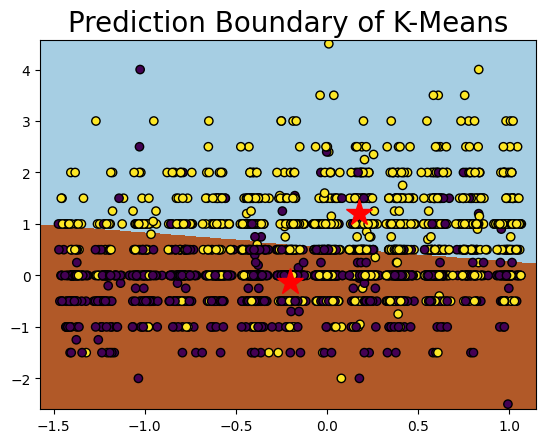

In [31]:
# K-means random
kmean1 = KMeans(n_clusters=2, init='random', random_state=0)
kmean1.fit(sX)
plot_decision_boundary(sX, sY, kmean1, "Prediction Boundary of K-Means")
plt.plot(kmean1.cluster_centers_[:, 0], kmean1.cluster_centers_[:, 1], '*', markersize=20, color="red")

/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


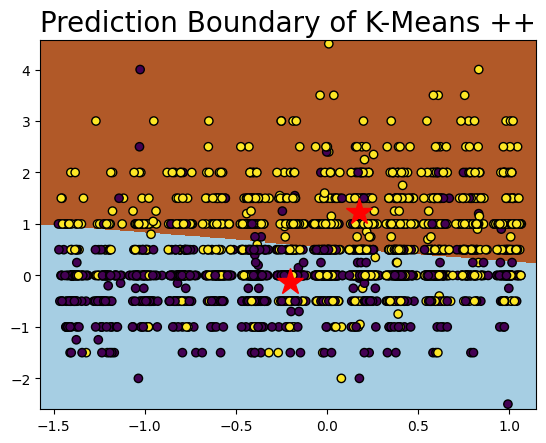

In [32]:
# K-means++
kmean2 = KMeans(n_clusters=2, init='k-means++', random_state=0)
kmean2.fit(sX)
plot_decision_boundary(sX, sY, kmean2, "Prediction Boundary of K-Means ++")
plt.plot(kmean2.cluster_centers_[:, 0], kmean2.cluster_centers_[:,1], '*', markersize=20, color="red")

In [33]:
# training accuracy scores
kmeans1_pred = kmean1.predict(sX) # K-means random
kmeans2_pred = kmean2.predict(sX) # K-means++
print('K-means(random) training accuracy: ', accuracy_score(sY, kmeans1_pred))
print('K-means++ training accuracy: ', accuracy_score(sY, kmeans2_pred), '\n')

# testing accuracy scores
kmeans1_pred_test = kmean1.predict(x_test[['age','ap_hi']]) # K-means random
kmeans2_pred_test = kmean2.predict(x_test[['age','ap_hi']]) # K-means++
print('K-means(random) testing accuracy: ', accuracy_score(y_test, kmeans1_pred_test))
print('K-means++ testing accuracy: ', accuracy_score(y_test, kmeans2_pred_test))

K-means(random) training accuracy:  0.2932
K-means++ training accuracy:  0.706 

K-means(random) testing accuracy:  0.2944515190103693
K-means++ testing accuracy:  0.7051482626887393


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


### Agglomerative Clustering

In [34]:
# function to plot dengrogram
def plot_dendrogram(model, **kwargs): # provided by Mathew Kallada. 

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0] + 2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    
    sch.dendrogram(linkage_matrix, **kwargs)

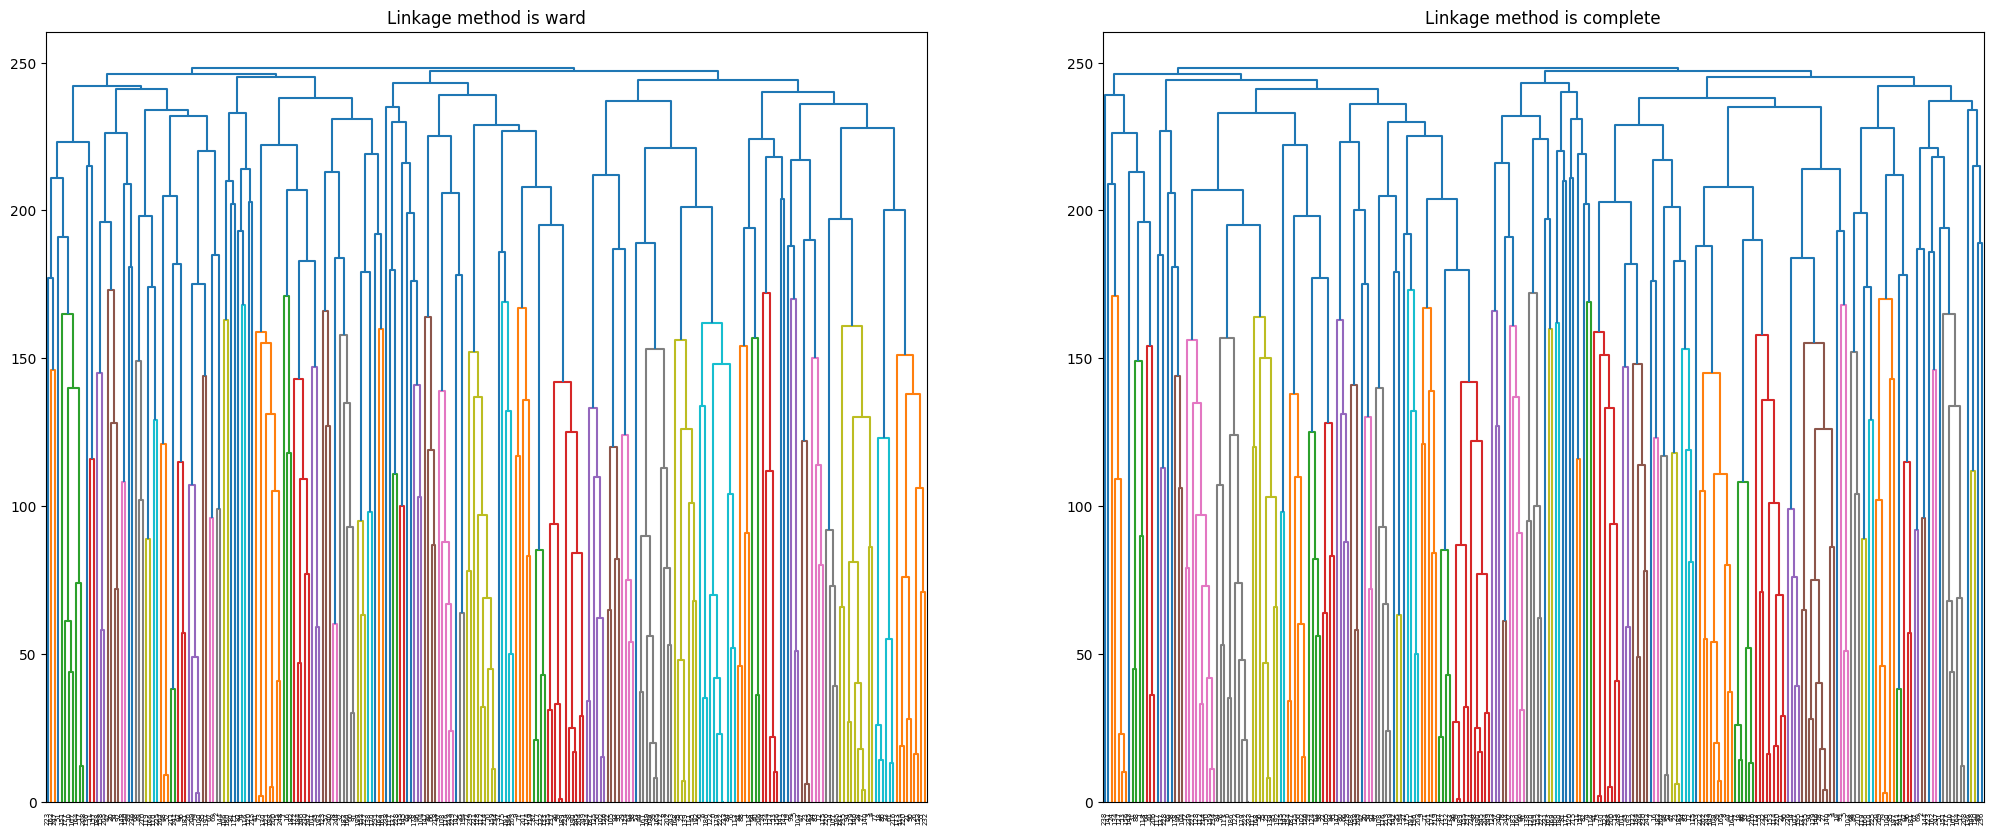

In [35]:
# ward's linkage and complete linkage
H_C_ward = AgglomerativeClustering(n_clusters=2) # default linkage is ward. 
H_C_complete = AgglomerativeClustering(n_clusters=2, linkage='complete')

# dendrogram (on 250 records only)
hc_ward_pred = H_C_ward.fit_predict(sX[0:250])
hc_complete_pred = H_C_complete.fit_predict(sX[0:250])

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 2, 1)
plot_dendrogram(H_C_ward)
ax.set_title('Linkage method is ward')

ax = fig.add_subplot(1, 2, 2)
Z2 = plot_dendrogram(H_C_complete)
ax.set_title('Linkage method is complete')
plt.show()

In [36]:
# accuracy score (on 2500 records)
hc_ward_pred = H_C_ward.fit_predict(sX)
hc_complete_pred = H_C_complete.fit_predict(sX)

print("ward's linkage training accuracy: ", accuracy_score(sY, hc_ward_pred))
print('complete linkage training accuracy: ', accuracy_score(sY, hc_complete_pred))

ward's linkage training accuracy:  0.6836
complete linkage training accuracy:  0.5152


### DBSCAN

In [37]:
# DBSCAN
dbscan = DBSCAN(eps=0.26, min_samples=20)
dbscan_pred = dbscan.fit_predict(sX)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan_pred)) - (1 if -1 in dbscan_pred else 0)
n_noise_ = list(dbscan_pred).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 125


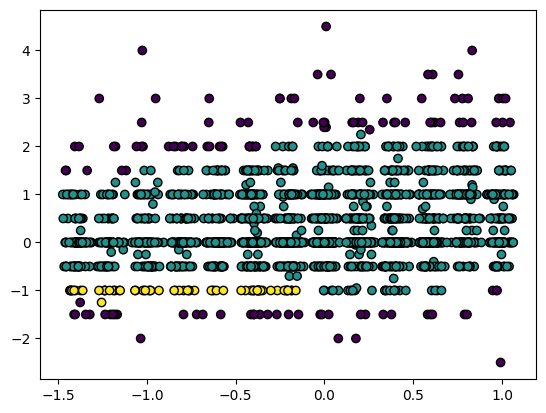

DBSCAN training accuracy:  0.4448


In [38]:
# plot
plt.scatter(x=sX[:,0], y=sX[:,1], c=dbscan_pred, edgecolors='k')
plt.show()

# accuracy score
print("DBSCAN training accuracy: ", accuracy_score(sY, dbscan_pred))

### Gaussian Mixture

/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


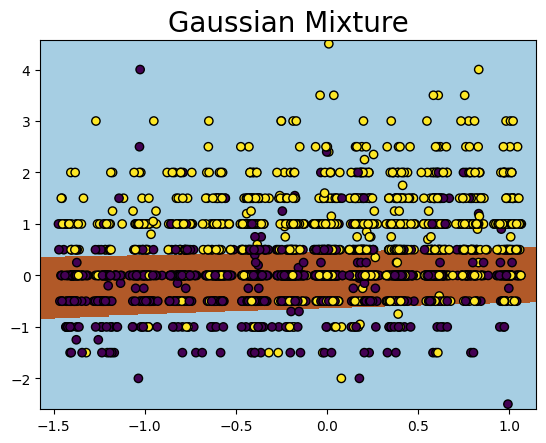

In [39]:
# Gaussian Mixture
gmm = GaussianMixture(n_components=2, covariance_type='full', max_iter=20, random_state=8017) 
gmm.fit(sX)
plot_decision_boundary(sX, sY, gmm, "Gaussian Mixture")

In [40]:
# training accuracy scores
gmm_pred = gmm.predict(sX)
print('Gaussian Mixture Model training accuracy: ', accuracy_score(sY, gmm_pred), '\n')

# testing accuracy scores
gmm_pred_test = gmm.predict(x_test[['age','ap_hi']])
print('Gaussian Mixture Model testing accuracy: ', accuracy_score(y_test, gmm_pred_test))

Gaussian Mixture Model training accuracy:  0.3324 

Gaussian Mixture Model testing accuracy:  0.3342186647262143


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


### Clustering Performance

In [41]:
# function to calculate entropy score
def get_entropy(y, pred, n_class):
    p = np.zeros((n_class, n_class))
    tb = contingency_matrix(y, pred)
    for i in range(n_class):
        for j in range(n_class):
            p[i, j] = tb[i, j]/np.sum(tb[i, :])
            
    E = np.zeros((n_class, 1))
    for i in range(n_class):
        for j in range(n_class):
            if (p[i, j] != 0):
                E[i] = E[i] - p[i, j] * np.log(p[i, j])
    Entropy = np.dot(np.sum(tb, 1) / np.sum(tb), E)
    return Entropy

In [42]:
# accuracy scores of all clustering
result = pd.DataFrame({'Model':['K-means (Random)','K-means (K-means++)','Dendrogram (Ward)','Dendrogram (Complete)','DBSCAN','Gaussian Mixture Model'],
                       'Training Accuracy': [accuracy_score(sY, kmeans1_pred),
                                             accuracy_score(sY, kmeans2_pred),
                                             accuracy_score(sY, hc_ward_pred),
                                             accuracy_score(sY, hc_complete_pred),
                                             accuracy_score(sY, dbscan_pred),
                                             accuracy_score(sY, gmm_pred)],
                       
                       # external measurement
                       'Entropy': [get_entropy(sY, kmeans1_pred, 2)[0], 
                                  get_entropy(sY, kmeans2_pred, 2)[0], 
                                  get_entropy(sY, hc_ward_pred, 2)[0], 
                                  get_entropy(sY, hc_complete_pred, 2)[0],
                                  get_entropy(sY, dbscan_pred, 2)[0], 
                                  get_entropy(sY, gmm_pred, 2)[0]],
                       'Adjusted Rand Index': [adjusted_rand_score(sY, kmeans1_pred), 
                                              adjusted_rand_score(sY, kmeans2_pred),
                                              adjusted_rand_score(sY, hc_ward_pred), 
                                              adjusted_rand_score(sY, hc_complete_pred), 
                                              adjusted_rand_score(sY, dbscan_pred), 
                                              adjusted_rand_score(sY, gmm_pred)],
                       
                       # internal measurement
                       'Silhouette Coefficient': [silhouette_score(sX, kmeans1_pred),
                                                 silhouette_score(sX, kmeans2_pred), 
                                                 silhouette_score(sX, hc_ward_pred),
                                                 silhouette_score(sX, hc_complete_pred),
                                                 silhouette_score(sX, dbscan_pred),
                                                 silhouette_score(sX, gmm_pred)],
                       'Calinski Harabasz Score': [calinski_harabasz_score(sX, kmeans1_pred),  #Ratio of between-cluster dispersion to within-cluster dispersion
                                                   calinski_harabasz_score(sX, kmeans2_pred), 
                                                   calinski_harabasz_score(sX, hc_ward_pred),
                                                   calinski_harabasz_score(sX, hc_complete_pred),
                                                   calinski_harabasz_score(sX, dbscan_pred),
                                                   calinski_harabasz_score(sX, gmm_pred)]
                      })
result

Model  Training Accuracy  Entropy  Adjusted Rand Index  \
0        K-means (Random)             0.2932   0.5345               0.1706   
1     K-means (K-means++)             0.7060   0.5346               0.1693   
2       Dendrogram (Ward)             0.6836   0.5200               0.1343   
3   Dendrogram (Complete)             0.5152   0.1542              -0.0005   
4                  DBSCAN             0.4448   0.2202               0.0019   
5  Gaussian Mixture Model             0.3324   0.6225               0.1120   

   Silhouette Coefficient  Calinski Harabasz Score  
0                  0.3948               1,715.3830  
1                  0.3951               1,715.3924  
2                  0.3933               1,591.1868  
3                  0.4433                 472.9488  
4                  0.2206                 120.8891  
5                  0.2794                 624.3443

**K-means has the highest training accuracy.**

**Dendrogram (Complete) works the best in entropy, while K-means (Random) works the best on adjusted rand index.**

**It can be observed that Dendrogram (Complete) works the best in silhouette score, while K-means (K-means++) works the best regarding calinski harabasz score.**

# Ensemble Methods

### Bagging Classifier

In [43]:
%%time

# parameters candidates
parameters = {'base_estimator__max_depth': [4,6,8,12,24],
              'n_estimators': [20, 50, 100, 200]}

# fitting
Bagging_GSCV = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(), random_state=8017), 
                            parameters, n_jobs=-1, verbose=3, return_train_score=True)
Bagging_GSCV.fit(x_train, y_train)
Bagging_model = Bagging_GSCV.best_estimator_
Bagging_model

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site

[CV 2/5] END base_estimator__max_depth=4, n_estimators=20;, score=(train=0.729, test=0.727) total time=   0.5s
[CV 1/5] END base_estimator__max_depth=4, n_estimators=20;, score=(train=0.728, test=0.733) total time=   0.5s
[CV 3/5] END base_estimator__max_depth=4, n_estimators=20;, score=(train=0.728, test=0.734) total time=   0.5s
[CV 4/5] END base_estimator__max_depth=4, n_estimators=20;, score=(train=0.731, test=0.720) total time=   0.5s
[CV 5/5] END base_estimator__max_depth=4, n_estimators=20;, score=(train=0.731, test=0.730) total time=   0.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site

[CV 1/5] END base_estimator__max_depth=4, n_estimators=50;, score=(train=0.728, test=0.734) total time=   1.2s
[CV 2/5] END base_estimator__max_depth=4, n_estimators=50;, score=(train=0.731, test=0.726) total time=   1.2s
[CV 3/5] END base_estimator__max_depth=4, n_estimators=50;, score=(train=0.728, test=0.734) total time=   1.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=4, n_estimators=50;, score=(train=0.731, test=0.729) total time=   1.2s
[CV 4/5] END base_estimator__max_depth=4, n_estimators=50;, score=(train=0.731, test=0.720) total time=   1.2s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=4, n_estimators=100;, score=(train=0.729, test=0.734) total time=   2.3s
[CV 1/5] END base_estimator__max_depth=4, n_estimators=100;, score=(train=0.728, test=0.733) total time=   2.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=4, n_estimators=100;, score=(train=0.729, test=0.726) total time=   2.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=4, n_estimators=100;, score=(train=0.731, test=0.720) total time=   2.5s
[CV 5/5] END base_estimator__max_depth=4, n_estimators=100;, score=(train=0.731, test=0.730) total time=   2.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=6, n_estimators=20;, score=(train=0.737, test=0.739) total time=   0.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=6, n_estimators=20;, score=(train=0.738, test=0.738) total time=   0.7s
[CV 2/5] END base_estimator__max_depth=6, n_estimators=20;, score=(train=0.738, test=0.730) total time=   0.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=6, n_estimators=20;, score=(train=0.740, test=0.725) total time=   0.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=6, n_estimators=20;, score=(train=0.739, test=0.731) total time=   0.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=6, n_estimators=50;, score=(train=0.737, test=0.741) total time=   1.7s
[CV 1/5] END base_estimator__max_depth=4, n_estimators=200;, score=(train=0.728, test=0.733) total time=   5.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=6, n_estimators=50;, score=(train=0.738, test=0.729) total time=   1.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=4, n_estimators=200;, score=(train=0.729, test=0.734) total time=   4.9s
[CV 2/5] END base_estimator__max_depth=4, n_estimators=200;, score=(train=0.729, test=0.727) total time=   5.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=6, n_estimators=50;, score=(train=0.738, test=0.738) total time=   1.9s
[CV 5/5] END base_estimator__max_depth=4, n_estimators=200;, score=(train=0.730, test=0.730) total time=   5.2s
[CV 4/5] END base_estimator__max_depth=6, n_estimators=50;, score=(train=0.740, test=0.726) total time=   1.9s
[CV 4/5] END base_estimator__max_depth=4, n_estimators=200;, score=(train=0.731, test=0.720) total time=   5.2s
[CV 5/5] END base_estimator__max_depth=6, n_estimators=50;, score=(train=0.739, test=0.730) total time=   1.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site

[CV 1/5] END base_estimator__max_depth=6, n_estimators=100;, score=(train=0.737, test=0.743) total time=   3.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=6, n_estimators=100;, score=(train=0.738, test=0.729) total time=   3.6s
[CV 3/5] END base_estimator__max_depth=6, n_estimators=100;, score=(train=0.738, test=0.739) total time=   3.6s
[CV 4/5] END base_estimator__max_depth=6, n_estimators=100;, score=(train=0.740, test=0.724) total time=   3.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=8, n_estimators=20;, score=(train=0.750, test=0.741) total time=   0.9s
[CV 2/5] END base_estimator__max_depth=8, n_estimators=20;, score=(train=0.751, test=0.728) total time=   0.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=6, n_estimators=100;, score=(train=0.740, test=0.729) total time=   3.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=8, n_estimators=20;, score=(train=0.753, test=0.725) total time=   0.8s
[CV 3/5] END base_estimator__max_depth=8, n_estimators=20;, score=(train=0.751, test=0.737) total time=   0.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=8, n_estimators=20;, score=(train=0.751, test=0.731) total time=   0.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=8, n_estimators=50;, score=(train=0.749, test=0.743) total time=   2.3s
[CV 2/5] END base_estimator__max_depth=8, n_estimators=50;, score=(train=0.752, test=0.728) total time=   2.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=8, n_estimators=50;, score=(train=0.752, test=0.737) total time=   2.2s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=6, n_estimators=200;, score=(train=0.736, test=0.742) total time=   7.1s
[CV 2/5] END base_estimator__max_depth=6, n_estimators=200;, score=(train=0.738, test=0.729) total time=   7.1s
[CV 3/5] END base_estimator__max_depth=6, n_estimators=200;, score=(train=0.738, test=0.738) total time=   7.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=8, n_estimators=50;, score=(train=0.753, test=0.726) total time=   2.2s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=8, n_estimators=50;, score=(train=0.751, test=0.730) total time=   2.3s
[CV 4/5] END base_estimator__max_depth=6, n_estimators=200;, score=(train=0.740, test=0.725) total time=   7.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=6, n_estimators=200;, score=(train=0.740, test=0.730) total time=   7.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=8, n_estimators=100;, score=(train=0.750, test=0.743) total time=   4.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=8, n_estimators=100;, score=(train=0.752, test=0.729) total time=   4.5s
[CV 4/5] END base_estimator__max_depth=8, n_estimators=100;, score=(train=0.754, test=0.725) total time=   4.5s
[CV 3/5] END base_estimator__max_depth=8, n_estimators=100;, score=(train=0.752, test=0.739) total time=   4.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=12, n_estimators=20;, score=(train=0.800, test=0.736) total time=   1.2s
[CV 5/5] END base_estimator__max_depth=8, n_estimators=100;, score=(train=0.753, test=0.730) total time=   4.4s
[CV 2/5] END base_estimator__max_depth=12, n_estimators=20;, score=(train=0.798, test=0.722) total time=   1.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=12, n_estimators=20;, score=(train=0.801, test=0.732) total time=   1.2s
[CV 4/5] END base_estimator__max_depth=12, n_estimators=20;, score=(train=0.799, test=0.722) total time=   1.3s
[CV 5/5] END base_estimator__max_depth=12, n_estimators=20;, score=(train=0.801, test=0.726) total time=   1.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=12, n_estimators=50;, score=(train=0.801, test=0.723) total time=   3.0s
[CV 1/5] END base_estimator__max_depth=12, n_estimators=50;, score=(train=0.801, test=0.738) total time=   3.1s
[CV 3/5] END base_estimator__max_depth=12, n_estimators=50;, score=(train=0.802, test=0.733) total time=   3.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=8, n_estimators=200;, score=(train=0.750, test=0.741) total time=   9.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=8, n_estimators=200;, score=(train=0.752, test=0.730) total time=   8.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=8, n_estimators=200;, score=(train=0.751, test=0.739) total time=   8.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=8, n_estimators=200;, score=(train=0.755, test=0.726) total time=   8.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=12, n_estimators=50;, score=(train=0.802, test=0.723) total time=   3.0s
[CV 5/5] END base_estimator__max_depth=8, n_estimators=200;, score=(train=0.753, test=0.730) total time=   8.7s
[CV 5/5] END base_estimator__max_depth=12, n_estimators=50;, score=(train=0.803, test=0.727) total time=   3.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=12, n_estimators=100;, score=(train=0.801, test=0.737) total time=   6.4s
[CV 2/5] END base_estimator__max_depth=12, n_estimators=100;, score=(train=0.803, test=0.723) total time=   6.2s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=12, n_estimators=100;, score=(train=0.803, test=0.735) total time=   6.2s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=12, n_estimators=100;, score=(train=0.802, test=0.722) total time=   6.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=24, n_estimators=20;, score=(train=0.964, test=0.712) total time=   1.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=12, n_estimators=100;, score=(train=0.804, test=0.727) total time=   6.3s
[CV 2/5] END base_estimator__max_depth=24, n_estimators=20;, score=(train=0.967, test=0.706) total time=   1.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=24, n_estimators=20;, score=(train=0.972, test=0.707) total time=   2.0s
[CV 4/5] END base_estimator__max_depth=24, n_estimators=20;, score=(train=0.966, test=0.702) total time=   1.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=24, n_estimators=20;, score=(train=0.968, test=0.703) total time=   1.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=24, n_estimators=50;, score=(train=0.972, test=0.718) total time=   4.7s
[CV 2/5] END base_estimator__max_depth=24, n_estimators=50;, score=(train=0.974, test=0.709) total time=   4.6s
[CV 2/5] END base_estimator__max_depth=12, n_estimators=200;, score=(train=0.803, test=0.725) total time=  12.7s
[CV 1/5] END base_estimator__max_depth=12, n_estimators=200;, score=(train=0.802, test=0.737) total time=  12.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site

[CV 3/5] END base_estimator__max_depth=12, n_estimators=200;, score=(train=0.804, test=0.736) total time=  12.7s
[CV 3/5] END base_estimator__max_depth=24, n_estimators=50;, score=(train=0.978, test=0.712) total time=   4.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=12, n_estimators=200;, score=(train=0.803, test=0.723) total time=  12.8s
[CV 5/5] END base_estimator__max_depth=12, n_estimators=200;, score=(train=0.805, test=0.727) total time=  12.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=24, n_estimators=50;, score=(train=0.976, test=0.711) total time=   4.8s
[CV 5/5] END base_estimator__max_depth=24, n_estimators=50;, score=(train=0.976, test=0.709) total time=   4.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=24, n_estimators=100;, score=(train=0.975, test=0.719) total time=   9.4s
[CV 2/5] END base_estimator__max_depth=24, n_estimators=100;, score=(train=0.978, test=0.714) total time=   9.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=24, n_estimators=100;, score=(train=0.978, test=0.716) total time=   9.6s
[CV 4/5] END base_estimator__max_depth=24, n_estimators=100;, score=(train=0.977, test=0.711) total time=   9.7s
[CV 5/5] END base_estimator__max_depth=24, n_estimators=100;, score=(train=0.978, test=0.713) total time=   9.1s
[CV 1/5] END base_estimator__max_depth=24, n_estimators=200;, score=(train=0.976, test=0.720) total time=  16.8s
[CV 2/5] END base_estimator__max_depth=24, n_estimators=200;, score=(train=0.979, test=0.713) total time=  16.4s
[CV 3/5] END base_estimator__max_depth=24, n_estimators=200;, score=(train=0.980, test=0.717) total time=  16.6s
[CV 4/5] END base_estimator__max_depth=24, n_estimators=200;, score=(train=0.977, test=0.712) total time=  15.7s
[CV 5/5] END base_estimator__max_depth=24, n_estimators=200;, score=(train=0.980, test=0.715) total time=  15.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:930: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  self.best_estimator_ = clone(base_estimator).set_params(


CPU times: user 8.61 s, sys: 235 ms, total: 8.85 s
Wall time: 1min 19s


BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=8),
                  n_estimators=200, random_state=8017)

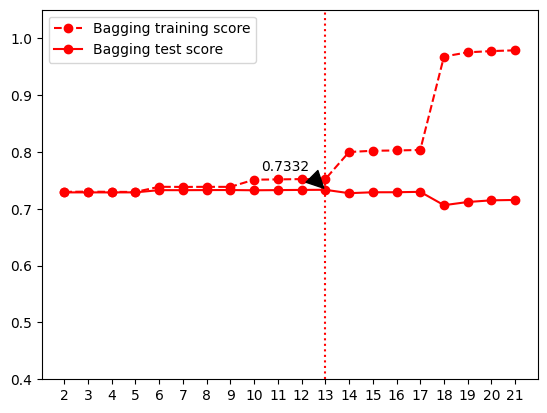

In [46]:
train_bagging_scores = Bagging_GSCV.cv_results_['mean_train_score']
test_bagging_scores = Bagging_GSCV.cv_results_['mean_test_score']

#plt.plot(test_dt_scores, 'go-')
plt.plot(train_bagging_scores, 'ro--')
plt.plot(test_bagging_scores, 'ro-')
plt.ylim(0.4, 1.05)
plt.xticks(range(20), range(2, 22))
plt.legend(["Bagging training score", "Bagging test score"])
plt.axvline(np.argmax(test_bagging_scores), linestyle="dotted", color="red")
plt.annotate(np.max(test_bagging_scores).round(4), (np.argmax(test_bagging_scores), np.max(test_bagging_scores)), xycoords="data",
                 xytext=(-40, 30), textcoords="offset pixels", arrowprops=dict(facecolor="black", shrink=0.1), fontsize=10,
                 horizontalalignment="center", verticalalignment="top")
plt.show()

In [47]:
# accuracy scores
print(Bagging_model.get_params())
print(f"Training Score: {round(Bagging_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(Bagging_model.score(x_test, y_test),4)}")

{'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 8, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=8), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 8017, 'verbose': 0, 'warm_start': False}
Training Score: 0.7496
Testing Score: 0.7328


### Random Forest Classifier

In [48]:
%%time

# parameters candidates
parameters = {'n_estimators': [20, 50, 100, 200],
              'max_depth':[6,8,12,24,48]}

# fitting
RandomForest_GSCV = GridSearchCV(RandomForestClassifier(random_state=8017), 
                                 parameters, n_jobs=-1, verbose=3)
RandomForest_GSCV.fit(x_train, y_train)
RandomForest_model = RandomForest_GSCV.best_estimator_
RandomForest_model

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ......max_depth=6, n_estimators=20;, score=0.736 total time=   0.2s
[CV 2/5] END ......max_depth=6, n_estimators=20;, score=0.731 total time=   0.2s
[CV 4/5] END ......max_depth=6, n_estimators=20;, score=0.722 total time=   0.2s
[CV 3/5] END ......max_depth=6, n_estimators=20;, score=0.734 total time=   0.3s
[CV 5/5] END ......max_depth=6, n_estimators=20;, score=0.727 total time=   0.3s
[CV 1/5] END ......max_depth=6, n_estimators=50;, score=0.735 total time=   0.6s
[CV 2/5] END ......max_depth=6, n_estimators=50;, score=0.729 total time=   0.6s
[CV 3/5] END ......max_depth=6, n_estimators=50;, score=0.734 total time=   0.6s
[CV 4/5] END ......max_depth=6, n_estimators=50;, score=0.723 total time=   0.6s
[CV 5/5] END ......max_depth=6, n_estimators=50;, score=0.727 total time=   0.7s
[CV 1/5] END .....max_depth=6, n_estimators=100;, score=0.736 total time=   1.2s
[CV 2/5] END .....max_depth=6, n_estimators=100

RandomForestClassifier(max_depth=12, n_estimators=200, random_state=8017)

In [49]:
# accuracy scores
print(RandomForest_model.get_params())
print(f"Training Score: {round(RandomForest_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(RandomForest_model.score(x_test, y_test),4)}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 8017, 'verbose': 0, 'warm_start': False}
Training Score: 0.7796
Testing Score: 0.7336


### Adaboost

In [50]:
%%time

# parameters candidates
parameters = {'base_estimator__max_depth': [2,3,4,6,8,12],
              'n_estimators': [20, 50, 100, 200]}

# fitting
Adaboost_GSCV = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(), random_state=8017), 
                             parameters, n_jobs=-1, verbose=3)
Adaboost_GSCV.fit(x_train, y_train)
Adaboost_model = Adaboost_GSCV.best_estimator_
Adaboost_model

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=2, n_estimators=20;, score=0.739 total time=   0.4s
[CV 2/5] END base_estimator__max_depth=2, n_estimators=20;, score=0.729 total time=   0.4s
[CV 3/5] END base_estimator__max_depth=2, n_estimators=20;, score=0.737 total time=   0.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.1

[CV 5/5] END base_estimator__max_depth=2, n_estimators=20;, score=0.731 total time=   0.4s
[CV 4/5] END base_estimator__max_depth=2, n_estimators=20;, score=0.724 total time=   0.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=2, n_estimators=50;, score=0.724 total time=   1.0s
[CV 5/5] END base_estimator__max_depth=2, n_estimators=50;, score=0.730 total time=   1.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=2, n_estimators=50;, score=0.728 total time=   1.1s
[CV 1/5] END base_estimator__max_depth=2, n_estimators=50;, score=0.739 total time=   1.1s
[CV 3/5] END base_estimator__max_depth=2, n_estimators=50;, score=0.735 total time=   1.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=2, n_estimators=100;, score=0.737 total time=   2.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=2, n_estimators=100;, score=0.730 total time=   2.1s
[CV 3/5] END base_estimator__max_depth=2, n_estimators=100;, score=0.736 total time=   2.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=2, n_estimators=100;, score=0.726 total time=   2.2s
[CV 5/5] END base_estimator__max_depth=2, n_estimators=100;, score=0.729 total time=   2.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=3, n_estimators=20;, score=0.739 total time=   0.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=3, n_estimators=20;, score=0.736 total time=   0.6s
[CV 2/5] END base_estimator__max_depth=3, n_estimators=20;, score=0.727 total time=   0.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=3, n_estimators=20;, score=0.725 total time=   0.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=3, n_estimators=20;, score=0.729 total time=   0.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=3, n_estimators=50;, score=0.737 total time=   1.5s
[CV 1/5] END base_estimator__max_depth=2, n_estimators=200;, score=0.736 total time=   4.1s
[CV 2/5] END base_estimator__max_depth=3, n_estimators=50;, score=0.725 total time=   1.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=2, n_estimators=200;, score=0.727 total time=   4.5s
[CV 3/5] END base_estimator__max_depth=2, n_estimators=200;, score=0.732 total time=   4.4s
[CV 3/5] END base_estimator__max_depth=3, n_estimators=50;, score=0.730 total time=   1.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=2, n_estimators=200;, score=0.721 total time=   4.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=3, n_estimators=50;, score=0.722 total time=   1.4s
[CV 5/5] END base_estimator__max_depth=3, n_estimators=50;, score=0.727 total time=   1.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=2, n_estimators=200;, score=0.725 total time=   4.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=3, n_estimators=100;, score=0.737 total time=   3.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=3, n_estimators=100;, score=0.719 total time=   3.1s
[CV 4/5] END base_estimator__max_depth=3, n_estimators=100;, score=0.715 total time=   3.2s
[CV 3/5] END base_estimator__max_depth=3, n_estimators=100;, score=0.726 total time=   3.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=3, n_estimators=100;, score=0.724 total time=   3.3s
[CV 1/5] END base_estimator__max_depth=4, n_estimators=20;, score=0.736 total time=   0.8s
[CV 2/5] END base_estimator__max_depth=4, n_estimators=20;, score=0.725 total time=   0.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=4, n_estimators=20;, score=0.736 total time=   0.8s
[CV 4/5] END base_estimator__max_depth=4, n_estimators=20;, score=0.725 total time=   0.8s
[CV 5/5] END base_estimator__max_depth=4, n_estimators=20;, score=0.727 total time=   0.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=4, n_estimators=50;, score=0.720 total time=   1.8s
[CV 1/5] END base_estimator__max_depth=4, n_estimators=50;, score=0.731 total time=   2.0s
[CV 3/5] END base_estimator__max_depth=4, n_estimators=50;, score=0.730 total time=   2.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=3, n_estimators=200;, score=0.713 total time=   6.2s
[CV 1/5] END base_estimator__max_depth=3, n_estimators=200;, score=0.726 total time=   6.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=3, n_estimators=200;, score=0.725 total time=   6.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=4, n_estimators=50;, score=0.719 total time=   2.0s
[CV 5/5] END base_estimator__max_depth=4, n_estimators=50;, score=0.725 total time=   2.0s
[CV 4/5] END base_estimator__max_depth=3, n_estimators=200;, score=0.709 total time=   6.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=3, n_estimators=200;, score=0.717 total time=   6.2s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=4, n_estimators=100;, score=0.719 total time=   3.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=4, n_estimators=100;, score=0.711 total time=   3.9s
[CV 3/5] END base_estimator__max_depth=4, n_estimators=100;, score=0.721 total time=   4.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=4, n_estimators=100;, score=0.713 total time=   3.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=6, n_estimators=20;, score=0.722 total time=   1.1s
[CV 2/5] END base_estimator__max_depth=6, n_estimators=20;, score=0.719 total time=   1.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=4, n_estimators=100;, score=0.716 total time=   3.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=6, n_estimators=20;, score=0.726 total time=   1.1s
[CV 4/5] END base_estimator__max_depth=6, n_estimators=20;, score=0.719 total time=   1.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=6, n_estimators=20;, score=0.712 total time=   1.1s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=6, n_estimators=50;, score=0.711 total time=   2.6s
[CV 2/5] END base_estimator__max_depth=6, n_estimators=50;, score=0.712 total time=   2.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=6, n_estimators=50;, score=0.710 total time=   2.6s
[CV 2/5] END base_estimator__max_depth=4, n_estimators=200;, score=0.704 total time=   7.7s
[CV 1/5] END base_estimator__max_depth=4, n_estimators=200;, score=0.704 total time=   7.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=4, n_estimators=200;, score=0.703 total time=   7.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=4, n_estimators=200;, score=0.700 total time=   7.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=4, n_estimators=200;, score=0.704 total time=   7.5s
[CV 4/5] END base_estimator__max_depth=6, n_estimators=50;, score=0.703 total time=   2.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=6, n_estimators=50;, score=0.707 total time=   2.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=6, n_estimators=100;, score=0.687 total time=   5.3s
[CV 2/5] END base_estimator__max_depth=6, n_estimators=100;, score=0.688 total time=   5.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=6, n_estimators=100;, score=0.689 total time=   5.4s
[CV 4/5] END base_estimator__max_depth=6, n_estimators=100;, score=0.687 total time=   5.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=6, n_estimators=100;, score=0.689 total time=   5.2s
[CV 1/5] END base_estimator__max_depth=8, n_estimators=20;, score=0.707 total time=   1.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=8, n_estimators=20;, score=0.710 total time=   1.4s
[CV 3/5] END base_estimator__max_depth=8, n_estimators=20;, score=0.711 total time=   1.6s
[CV 4/5] END base_estimator__max_depth=8, n_estimators=20;, score=0.702 total time=   1.7s
[CV 5/5] END base_estimator__max_depth=8, n_estimators=20;, score=0.704 total time=   1.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=8, n_estimators=50;, score=0.681 total time=   3.5s
[CV 1/5] END base_estimator__max_depth=8, n_estimators=50;, score=0.679 total time=   3.5s
[CV 3/5] END base_estimator__max_depth=8, n_estimators=50;, score=0.687 total time=   3.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=6, n_estimators=200;, score=0.668 total time=  10.9s
[CV 2/5] END base_estimator__max_depth=6, n_estimators=200;, score=0.662 total time=  10.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=6, n_estimators=200;, score=0.669 total time=  10.9s
[CV 5/5] END base_estimator__max_depth=8, n_estimators=50;, score=0.686 total time=   3.4s
[CV 4/5] END base_estimator__max_depth=8, n_estimators=50;, score=0.669 total time=   3.4s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=6, n_estimators=200;, score=0.664 total time=  10.9s
[CV 5/5] END base_estimator__max_depth=6, n_estimators=200;, score=0.658 total time=  10.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=8, n_estimators=100;, score=0.669 total time=   6.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=8, n_estimators=100;, score=0.660 total time=   6.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=8, n_estimators=100;, score=0.668 total time=   6.8s
[CV 4/5] END base_estimator__max_depth=8, n_estimators=100;, score=0.639 total time=   6.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=12, n_estimators=20;, score=0.666 total time=   2.0s
[CV 1/5] END base_estimator__max_depth=12, n_estimators=20;, score=0.672 total time=   2.0s
[CV 5/5] END base_estimator__max_depth=8, n_estimators=100;, score=0.659 total time=   6.6s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=12, n_estimators=20;, score=0.665 total time=   1.9s
[CV 4/5] END base_estimator__max_depth=12, n_estimators=20;, score=0.662 total time=   2.0s
[CV 5/5] END base_estimator__max_depth=12, n_estimators=20;, score=0.678 total time=   1.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=12, n_estimators=50;, score=0.670 total time=   4.8s
[CV 2/5] END base_estimator__max_depth=12, n_estimators=50;, score=0.665 total time=   4.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=12, n_estimators=50;, score=0.665 total time=   4.9s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=8, n_estimators=200;, score=0.662 total time=  13.8s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 3/5] END base_estimator__max_depth=8, n_estimators=200;, score=0.667 total time=  13.4s
[CV 2/5] END base_estimator__max_depth=8, n_estimators=200;, score=0.662 total time=  13.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=8, n_estimators=200;, score=0.658 total time=  13.5s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 5/5] END base_estimator__max_depth=8, n_estimators=200;, score=0.664 total time=  13.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=12, n_estimators=50;, score=0.669 total time=   4.9s
[CV 5/5] END base_estimator__max_depth=12, n_estimators=50;, score=0.666 total time=   5.0s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))
/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 1/5] END base_estimator__max_depth=12, n_estimators=100;, score=0.689 total time=   8.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 2/5] END base_estimator__max_depth=12, n_estimators=100;, score=0.684 total time=   8.5s
[CV 3/5] END base_estimator__max_depth=12, n_estimators=100;, score=0.684 total time=   8.3s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  estimator = estimator.set_params(**clone(parameters, safe=False))


[CV 4/5] END base_estimator__max_depth=12, n_estimators=100;, score=0.683 total time=   8.5s
[CV 5/5] END base_estimator__max_depth=12, n_estimators=100;, score=0.684 total time=   8.4s
[CV 1/5] END base_estimator__max_depth=12, n_estimators=200;, score=0.689 total time=  10.1s
[CV 2/5] END base_estimator__max_depth=12, n_estimators=200;, score=0.683 total time=  10.4s
[CV 3/5] END base_estimator__max_depth=12, n_estimators=200;, score=0.684 total time=  11.2s
[CV 4/5] END base_estimator__max_depth=12, n_estimators=200;, score=0.684 total time=   9.6s
[CV 5/5] END base_estimator__max_depth=12, n_estimators=200;, score=0.686 total time=   9.7s


/Users/vsaravind/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:930: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  self.best_estimator_ = clone(base_estimator).set_params(


CPU times: user 902 ms, sys: 262 ms, total: 1.16 s
Wall time: 1min 11s


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=20, random_state=8017)

In [51]:
# accuracy scores
print(Adaboost_model.get_params())
print(f"Training Score: {round(Adaboost_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(Adaboost_model.score(x_test, y_test),4)}")

{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 1.0, 'n_estimators': 20, 'random_state': 8017}
Training Score: 0.7335
Testing Score: 0.7315


### Gradient Boosting

In [52]:
%%time

# parameters candidates
parameters = {'max_depth': [2,4,6,8,10,12],
              'n_estimators': [200],
              'learning_rate': [0.01]}

# fitting
GradientBoost_GSCV = GridSearchCV(GradientBoostingClassifier(random_state=8017), 
                             parameters, n_jobs=-1, verbose=3)
GradientBoost_GSCV.fit(x_train, y_train)
GradientBoost_model = GradientBoost_GSCV.best_estimator_
GradientBoost_model

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.728 total time=   3.5s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.726 total time=   3.6s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.724 total time=   3.6s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.717 total time=   3.6s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.724 total time=   3.6s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.729 total time=   6.8s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.738 total time=   6.8s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.734 total time=   6.9s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.729 total time=   6.7s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=0.725

GradientBoostingClassifier(learning_rate=0.01, max_depth=6, n_estimators=200,
                           random_state=8017)

In [53]:
# accuracy scores
print(GradientBoost_model.get_params())
print(f"Training Score: {round(GradientBoost_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(GradientBoost_model.score(x_test, y_test),4)}")

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 8017, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.7438
Testing Score: 0.7332


# Support Vector Machine

### Linear SVC

In [54]:
%%time

# parameters candidates
parameters = {'C': np.logspace(-4, 4, 50)}

# fitting
LinearSVC_GSCV = GridSearchCV(LinearSVC(dual=False, random_state=8017), 
                              parameters, n_jobs=-1, verbose=3)
LinearSVC_GSCV.fit(x_train, y_train)
LinearSVC_model = LinearSVC_GSCV.best_estimator_
LinearSVC_model


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 3/5] END ..........................C=0.0001;, score=0.730 total time=   0.0s
[CV 1/5] END ..........................C=0.0001;, score=0.732 total time=   0.0s
[CV 2/5] END ..........................C=0.0001;, score=0.725 total time=   0.0s
[CV 4/5] END ..........................C=0.0001;, score=0.717 total time=   0.0s
[CV 5/5] END ..........................C=0.0001;, score=0.727 total time=   0.0s
[CV 1/5] END ..........C=0.00014563484775012445;, score=0.732 total time=   0.0s
[CV 2/5] END ..........C=0.00014563484775012445;, score=0.724 total time=   0.0s
[CV 3/5] END ..........C=0.00014563484775012445;, score=0.730 total time=   0.0s
[CV 5/5] END ..........C=0.00014563484775012445;, score=0.725 total time=   0.0s
[CV 4/5] END ..........C=0.00014563484775012445;, score=0.719 total time=   0.0s
[CV 1/5] END ..........C=0.00021209508879201905;, score=0.732 total time=   0.0s
[CV 2/5] END ..........C=0.00021209508879201905

LinearSVC(C=0.004291934260128779, dual=False, random_state=8017)

In [55]:
# accuracy scores
print(LinearSVC_model.get_params())
print(f"Training Score: {round(LinearSVC_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(LinearSVC_model.score(x_test, y_test),4)}")

{'C': 0.004291934260128779, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 8017, 'tol': 0.0001, 'verbose': 0}
Training Score: 0.7262
Testing Score: 0.7263


### Non-Linear SVC

In [56]:
%%time

# fitting
SVC_model = SVC(kernel='rbf', random_state=8017)
SVC_model.fit(x_train, y_train)
SVC_model

CPU times: user 25.4 s, sys: 110 ms, total: 25.5 s
Wall time: 25.7 s


SVC(random_state=8017)

In [57]:
%%time

# accuracy scores
print(SVC_model.get_params())
print(f"Training Score: {round(SVC_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(SVC_model.score(x_test, y_test),4)}")

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 8017, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Training Score: 0.738
Testing Score: 0.7313
CPU times: user 55.3 s, sys: 66.6 ms, total: 55.3 s
Wall time: 55.9 s


# MLP

In [58]:
# layer sizes candidates
ls = [x for x in [4,8,16,32]] + [x for x in product([2,4,8], [4,8])] + [x for x in product([2,4,8], [8,16], [4,8])]
ls

[4,
 8,
 16,
 32,
 (2, 4),
 (2, 8),
 (4, 4),
 (4, 8),
 (8, 4),
 (8, 8),
 (2, 8, 4),
 (2, 8, 8),
 (2, 16, 4),
 (2, 16, 8),
 (4, 8, 4),
 (4, 8, 8),
 (4, 16, 4),
 (4, 16, 8),
 (8, 8, 4),
 (8, 8, 8),
 (8, 16, 4),
 (8, 16, 8)]

In [59]:
%%time

# parameters candidates
parameters = {'hidden_layer_sizes': ls}

# fitting
MLP_GSCV = GridSearchCV(MLPClassifier(random_state=8017), 
                        parameters, n_jobs=-1, verbose=3)
MLP_GSCV.fit(x_train, y_train)
MLP_model = MLP_GSCV.best_estimator_
MLP_model

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV 1/5] END ..............hidden_layer_sizes=4;, score=0.734 total time=   0.9s
[CV 2/5] END ..............hidden_layer_sizes=4;, score=0.730 total time=   1.0s
[CV 5/5] END ..............hidden_layer_sizes=4;, score=0.727 total time=   1.1s
[CV 4/5] END ..............hidden_layer_sizes=4;, score=0.727 total time=   1.3s
[CV 3/5] END ..............hidden_layer_sizes=8;, score=0.735 total time=   1.5s
[CV 3/5] END ..............hidden_layer_sizes=4;, score=0.733 total time=   1.6s
[CV 1/5] END ..............hidden_layer_sizes=8;, score=0.738 total time=   2.0s
[CV 4/5] END ..............hidden_layer_sizes=8;, score=0.727 total time=   1.5s
[CV 5/5] END ..............hidden_layer_sizes=8;, score=0.730 total time=   1.5s
[CV 1/5] END .............hidden_layer_sizes=16;, score=0.740 total time=   1.5s
[CV 2/5] END ..............hidden_layer_sizes=8;, score=0.731 total time=   2.8s
[CV 3/5] END .............hidden_layer_sizes=16

MLPClassifier(hidden_layer_sizes=(8, 16, 4), random_state=8017)

In [60]:
# top 10 cv scores for the MLP candidates
pd.DataFrame(MLP_GSCV.cv_results_).sort_values('rank_test_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
20         3.8226        0.3943           0.0029          0.0019   
21         3.0272        0.4932           0.0020          0.0002   
18         3.6787        0.2101           0.0027          0.0020   
3          2.8205        0.5788           0.0023          0.0008   
2          1.6816        0.1584           0.0035          0.0025   
9          2.4776        0.3624           0.0017          0.0001   
1          1.8529        0.5030           0.0015          0.0001   
19         3.9585        0.9244           0.0074          0.0112   
16         2.7214        0.3001           0.0020          0.0004   
8          1.9355        0.3118           0.0017          0.0001   

   param_hidden_layer_sizes                              params  \
20               (8, 16, 4)  {'hidden_layer_sizes': (8, 16, 4)}   
21               (8, 16, 8)  {'hidden_layer_sizes': (8, 16, 8)}   
18                (8, 8, 4)   {'hidden_layer_sizes': (8, 8, 4)}   
3                        32          {'hidden_layer_sizes': 32}   
2                        16          {'hidden_layer_sizes': 16}   
9                    (8, 8)      {'hidden_layer_sizes': (8, 8)}   
1                         8           {'hidden_layer_sizes': 8}   
19                (8, 8, 8)   {'hidden_layer_sizes': (8, 8, 8)}   
16               (4, 16, 4)  {'hidden_layer_sizes': (4, 16, 4)}   
8                    (8, 4)      {'hidden_layer_sizes': (8, 4)}   

    split0_test_score  split1_test_score  split2_test_score  \
20             0.7430             0.7318             0.7358   
21             0.7379             0.7349             0.7374   
18             0.7419             0.7299             0.7373   
3              0.7406             0.7300             0.7349   
2              0.7395             0.7295             0.7346   
9              0.7385             0.7304             0.7358   
1              0.7382             0.7310             0.7346   
19             0.7398             0.7278             0.7371   
16             0.7364             0.7290             0.7369   
8              0.7378             0.7287             0.7351   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
20             0.7265             0.7309           0.7336          0.0056   
21             0.7257             0.7321           0.7336          0.0045   
18             0.7267             0.7320           0.7336          0.0054   
3              0.7266             0.7321           0.7328          0.0047   
2              0.7280             0.7305           0.7324          0.0042   
9              0.7257             0.7309           0.7323          0.0045   
1              0.7275             0.7295           0.7322          0.0038   
19             0.7244             0.7298           0.7318          0.0057   
16             0.7261             0.7300           0.7317          0.0042   
8              0.7223             0.7339           0.7316          0.0055   

    rank_test_score  
20                1  
21                2  
18                3  
3                 4  
2                 5  
9                 6  
1                 7  
19                8  
16                9  
8                10

In [61]:
# scores
print(MLP_model)
print(f"Training Score: {round(MLP_model.score(x_train, y_train),4)}")
print(f"Testing Score: {round(MLP_model.score(x_test, y_test),4)}")

MLPClassifier(hidden_layer_sizes=(8, 16, 4), random_state=8017)
Training Score: 0.7363
Testing Score: 0.7331


# Compare All Models

In [62]:
# accuracy scores of all models
result = pd.DataFrame({'Model':['Decision Tree','Logistic',
                                'Bagging','Random Forest','Adaboost','Gradient Boost',
                                'Linear SVC','Non-linear SVC','MLP'],
                       'Prediction Accuracy': [DecisionTree_model.score(x_test, y_test),
                                               Logistic_model.score(x_test, y_test),
                                               Bagging_model.score(x_test, y_test),
                                               RandomForest_model.score(x_test, y_test),
                                               Adaboost_model.score(x_test, y_test),
                                               GradientBoost_model.score(x_test, y_test),
                                               LinearSVC_model.score(x_test, y_test),
                                               SVC_model.score(x_test, y_test),
                                               MLP_model.score(x_test, y_test)]}
                     )
result.sort_values('Prediction Accuracy', ascending=False)

Model  Prediction Accuracy
3   Random Forest               0.7336
5  Gradient Boost               0.7332
8             MLP               0.7331
2         Bagging               0.7328
4        Adaboost               0.7315
7  Non-linear SVC               0.7313
0   Decision Tree               0.7276
1        Logistic               0.7274
6      Linear SVC               0.7263

# Classification Report & Confusion Matrix

In [63]:
def plot_confusion_matrix(classifier, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pred_train = classifier.predict_proba(x_train)
    pred_test = classifier.predict_proba(x_test)
    acc_train = accuracy_score(y_train, np.argmax(pred_train, 1))
    acc_test = accuracy_score(y_test, np.argmax(pred_test, 1))

    print("Training ACC:", round(acc_train, 4), "Testing ACC:", round(acc_test, 4))
    cm = confusion_matrix(y_test, np.argmax(pred_test, 1))
    print("Confusion matrix: \n", cm)
    print("Testing:\n",classification_report(y_test, np.argmax(pred_test, 1), target_names=classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Training ACC: 0.7796 Testing ACC: 0.7336
Confusion matrix: 
 [[10883  2980]
 [ 4343  9279]]
Testing:
               precision    recall  f1-score   support

          No       0.71      0.79      0.75     13863
         Yes       0.76      0.68      0.72     13622

    accuracy                           0.73     27485
   macro avg       0.74      0.73      0.73     27485
weighted avg       0.74      0.73      0.73     27485

Confusion matrix, without normalization


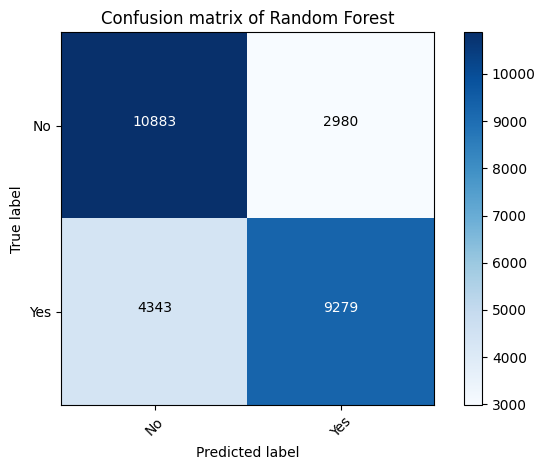

In [64]:
plot_confusion_matrix(RandomForest_model, classes=['No','Yes'],
                      title='Confusion matrix of Random Forest')

Training ACC: 0.7354 Testing ACC: 0.7276
Confusion matrix: 
 [[11048  2815]
 [ 4671  8951]]
Testing:
               precision    recall  f1-score   support

          No       0.70      0.80      0.75     13863
         Yes       0.76      0.66      0.71     13622

    accuracy                           0.73     27485
   macro avg       0.73      0.73      0.73     27485
weighted avg       0.73      0.73      0.73     27485

Confusion matrix, without normalization


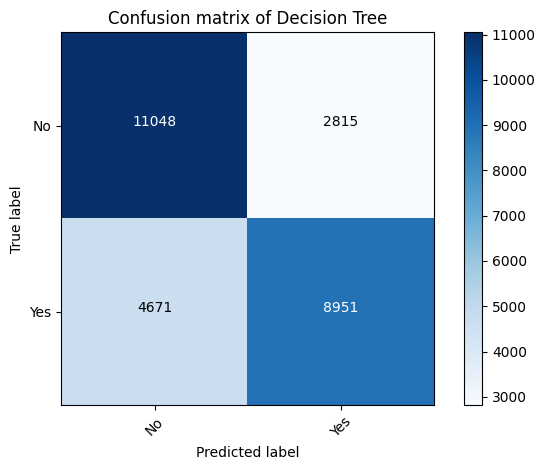

In [65]:
plot_confusion_matrix(DecisionTree_model, classes=['No','Yes'],
                      title='Confusion matrix of Decision Tree')

Training ACC: 0.7276 Testing ACC: 0.7274
Confusion matrix: 
 [[10877  2986]
 [ 4506  9116]]
Testing:
               precision    recall  f1-score   support

          No       0.71      0.78      0.74     13863
         Yes       0.75      0.67      0.71     13622

    accuracy                           0.73     27485
   macro avg       0.73      0.73      0.73     27485
weighted avg       0.73      0.73      0.73     27485

Confusion matrix, without normalization


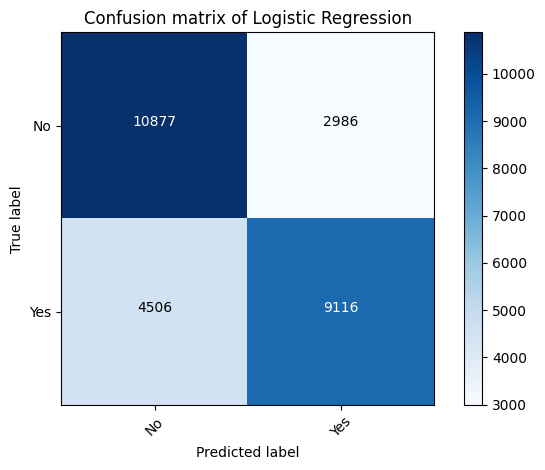

In [66]:
plot_confusion_matrix(Logistic_model, classes=['No','Yes'],
                      title='Confusion matrix of Logistic Regression')

# ROC Curve

In [67]:
yy_test = label_binarize(y_test, classes=[0, 1])
plt.figure(figsize=(20, 20))
def plot_roc_curve(classifier, label):
    # Compute ROC curve and ROC area for each class
    fpr = []
    tpr = []
    roc_auc = []
    pred_test = classifier.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(yy_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=label+(' (area = %0.4f)' % roc_auc))
def show_roc_curve():
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

<Figure size 2000x2000 with 0 Axes>

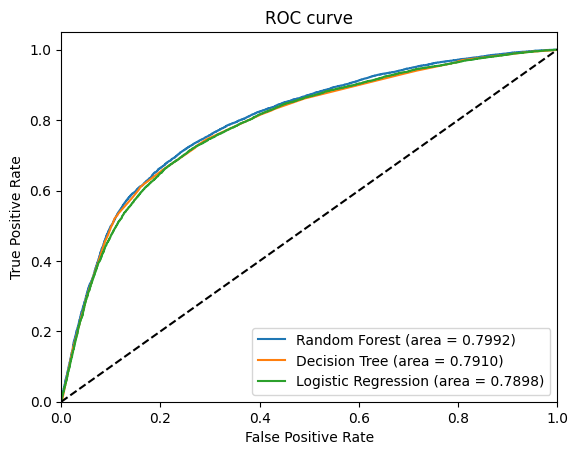

In [68]:
plot_roc_curve(RandomForest_model, label='Random Forest')
plot_roc_curve(DecisionTree_model, label='Decision Tree')
plot_roc_curve(Logistic_model, label='Logistic Regression')
show_roc_curve()